# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения, с целью предсказания коэффициента восстановления золота из золотосодержащей руды. Имеются данные с параметрами добычи и очистки.

Цель модели - оптимизация производства, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

### Введение

**Данные находятся в трёх файлах:**

- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

**Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.**

**Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.**

**Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.**

**В нашем распоряжении сырые данные: их просто выгрузили из хранилища.**

### Технологический процесс
**Как золото получают из руды?
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.**

![ru_final_smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/ru_process.png)

Опишем каждую стадию:

**1. Флотация**

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

**2. Очистка**

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

**Описание данных**

**Технологический процесс**

- *Rougher feed*** — исходное сырье
- *Rougher additions (или reagent additions)*** — флотационные реагенты: Xanthate, Sulphate, Depressant
  - *Xanthate* — ксантогенат (промотер, или активатор флотации);
  - *Sulphate* — сульфат (на данном производстве сульфид натрия);
  - *Depressant* — депрессант (силикат натрия).
- *Rougher process* (англ. «грубый процесс») — флотация
- *Rougher tails* — отвальные хвосты
- *Float banks* — флотационная установка
- *Cleaner process* — очистка
- *Rougher Au* — черновой концентрат золота
- *Final Au* — финальный концентрат золота

**Параметры этапов**
- *air amount* — объём воздуха
- *fluid levels* — уровень жидкости
- *feed size* — размер гранул сырья
- *feed rate* — скорость подачи

**Наименование признаков**

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`


Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:
- *rougher* — флотация
- *primary_cleaner* — первичная очистка
- *secondary_cleaner* — вторичная очистка
- *final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
- *input* — параметры сырья
- *output* — параметры продукта
- *state* — параметры, характеризующие текущее состояние этапа
- *calculation* — расчётные характеристики

**Расчёт эффективности**

Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды. .
Эффективность обогащения рассчитывается по формуле

![recovery](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/recovery.png)

где:
- *C* — доля золота в концентрате после флотации/очистки;
- *F* — доля золота в сырье/концентрате до флотации/очистки;
- *T* — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах.

Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества**
Для решения задачи введём новую метрику качества — **sMAPE** (англ. *Symmetric Mean Absolute Percentage Error*, «симметричное среднее абсолютное процентное отклонение»).

Она похожа на *MAE*, но выражается не в абсолютных величинах, а в относительных. Почему *симметричная*? Она одинаково учитывает масштаб и целевого признака, и предсказания.

Метрика *sMAPE* вычисляется так:

![smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/smape.png)

**Обозначения:**

- ***Yi*** - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

- ***Ẏi*** - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

- ***N*** - Количество объектов в выборке.

- ***Σ*** - Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины (целевые признаки):

1. эффективность обогащения чернового концентрата `rougher.output.recovery`;
2. эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:

![ru_final_smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/ru_final_smape.png)

### Подготовим неоходимые для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import make_scorer

from google.colab import drive
drive.mount('/content/drive')

### Изучим данные внутри датафрейма и сделаем необходимую предобработку

In [ ]:
train = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_train_new.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_test_new.csv', parse_dates=['date'])
data = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_full_new.csv', parse_dates=['date'])

data_list = [data, train, test]
pd.set_option('max_columns', None)

for df in data_list:
    display(df.head(100)); #выведем первые 5 строк датасета
    display(df.info()); #выведем информацию о типах данных и пропусках в датасете
    print('Количество дубликатов =', df['date'].duplicated().sum()) # кол-во дубликатов по дате/времени
    display(df.describe()); #выведем информацию о распределении значений в датасете
    display(df.corr()); #посмотрим корреляцию между признаками
    print('\n\n')

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final.

None

Количество дубликатов = 0


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.063570,0.380142,-0.038373,0.185952,0.334596,-0.051855,0.028890,0.206569,0.071158,0.127827,0.040543,0.127175,0.509877,-0.152814,0.332771,-0.200367,0.043138,-0.023182,0.175824,0.163903,0.175978,0.039789,0.194615,0.058284,0.154360,0.036542,0.110360,-0.001388,-0.014190,-0.034702,-0.039130,0.158668,0.456279,0.074866,-0.167154,-0.043895,-0.036783,0.315817,-0.096561,0.093678,-0.113477,0.114032,0.315558,-0.127291,-0.018497,0.044347,0.084148,0.204522,-0.049453,0.008952,0.125401,0.102807,-0.206426,0.086768,0.094650,0.079634,0.099465,0.094354,0.094249,0.135264,0.104504,0.091003,0.097289,-0.039046,-0.286238,0.157687,0.048926,-0.058101,0.024641,-0.016135,0.024709,0.061833,0.116037,0.065680,0.138392,0.027343,0.104118,0.029887,-0.063246,-0.004246,0.184332,0.003693,0.156471,0.162591,0.059581
final.output.concentrate_pb,0.063570,1.000000,-0.048586,0.374400,0.151987,-0.126886,0.221372,0.094385,-0.047446,0.079160,0.037710,-0.083249,-0.080320,-0.036563,0.377527,-0.110350,0.010703,-0.021533,0.026415,-0.048739,-0.138511,-0.002548,0.075751,-0.02

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14049 non-null  float64       
 8   final.

None

Количество дубликатов = 0


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.021110,0.351985,-0.104934,0.133238,0.289552,-0.099818,0.045896,0.193935,0.015923,0.136008,0.024921,0.165403,0.502774,-0.176998,0.315810,-0.185916,-0.001483,-0.062081,0.165046,0.191298,0.188219,0.041814,0.203256,0.053429,0.165760,0.043158,0.098070,0.007139,-0.016921,-0.027763,-0.037668,0.195373,0.424378,0.004272,-0.177363,-0.021952,-0.045802,0.276645,-0.115623,0.069868,-0.140668,0.087768,0.288717,-0.167535,-0.042561,0.033109,0.037976,0.191569,-0.032464,0.023109,0.131941,0.115834,-0.188839,0.119946,0.083973,0.099507,0.087969,0.129379,0.083580,0.187447,0.100778,0.153916,0.097132,-0.080417,-0.309225,0.142095,0.044370,-0.061512,0.036827,-0.025608,0.039360,0.054267,0.180700,0.027815,0.208832,0.041765,0.169538,0.020832,0.005319,0.013019,0.228753,0.021660,0.199048,0.170298,0.061009
final.output.concentrate_pb,0.021110,1.000000,-0.008451,0.320916,0.095000,-0.100616,0.240650,0.068287,0.029186,0.124170,0.012164,-0.051249,-0.179346,-0.031388,0.390204,-0.081883,0.008804,-0.042722,0.004041,-0.019916,-0.127692,-0.023678,0.062319,-0.04317

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

None

Количество дубликатов = 0


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.000000,0.455718,0.114456,0.497568,0.102653,0.048032,0.075737,0.138949,0.024710,0.027697,0.095001,-0.020533,0.359619,0.428382,0.464251,-0.009796,0.423859,0.437016,0.617768,0.557307,0.583022,0.527014,0.236898,0.222913,-0.230670,-0.047665,-0.247043,-0.051896,-0.247163,-0.016032,-0.234958,-0.120379,-0.250187,-0.063497,0.051989,-0.039145,0.254702,-0.011921,0.136986,0.003869,0.148037,0.020303,0.305793,0.117976,0.348395,0.068693,0.093608,0.132193,0.156583,0.072618,-0.134499,0.033945
primary_cleaner.input.depressant,0.455718,1.000000,0.215703,0.150760,0.144443,0.242592,0.148658,0.201499,0.036655,0.207632,0.141651,0.082802,0.497866,0.465961,0.132437,0.004431,0.169735,0.460965,0.240528,0.347558,0.208050,0.361123,0.422574,0.133122,-0.355519,-0.112394,-0.366098,-0.102649,-0.346803,-0.079246,-0.361011,-0.129417,-0.376446,-0.110906,0.084117,-0.084408,0.234562,-0.098847,0.282703,0.125933,0.256512,0.115952,0.326090,0.117510,0.238618,-0.085583,-0.090184,0.009138,0.064209,0.002988,-0.198422,0.034654
primary_cleaner.input.feed_size,0.114456,0.215703,1.000000,-0.291792,-0.064628,0.082869,-0.063490,0.071470,-0.091542,0.066384,-0.074156,0.065808,0.338795,0.000398,0.020000,-0.087331,0.054595,0.238692,-0.187934,0.224360,-0.236345,0.185176,0.023678,-0.236632,0.044605,0.051614,0.064617,0.049608,-0.009526,0.073623,-0.012558,0.006890,-0.129796,0.036627,-0.128933,0.044605,-0.184586,0.005911,0.024193,0.032868,-0.017527,0.025709,-0.148328,-0.121148,-0.173658,-0.137180,-0.192880,-0.059167,-0.214970,-0.054173,0.026930,-0.083021
primary_cleaner.input.xanthate,0.497568,0.150760,-0.291792,1.000000,0.209017,-0.059553,0.153527,0.016144,0.044194,-0.078742,0.174791,-0.144240,0.048319,0.241138,0.464682,0.195665,0.370448,0.093609,0.581118,0.350009,0.593851,0.368205,0.402757,0.424760,-0.387143,-0.342816,-0.405743,-0.346091,-0.392980,-0.326506,-0.321572,-0.363457,-0.290621,-0.333947,-0.038919,-0.162965,0.220744,-0.113589,-0.049184,-0.034554,-0.050835,-0.009169,0.313377,0.131178,0.360961,0.121575,0.059162,0.128636,0.077380,0.095508,-0.218155,0.080662
primary_cleaner.state.floatbank8_a_air,0.102653,0.14

**Проверим, что эффективность обогащения рассчитана правильно и предполагаемые к использованию данные корректны. Для этого вычислим её на обучающей выборке для признака `rougher.output.recovery` и найдем MAE между расчётным значением и значением признака.**

In [ ]:
def mae_recovery_calc(data,c,f,t,recovery):
    """
    Функция для расчета MAE между расчетным значением Recovery и значением признака из датасета.
    df — датасет,
    recovery — название признака в датафрейме,
    c — название признака в датафрейме, соот-го доле золота в концентрате после флотации/очистки,
    f — название признака в датафрейме, соот-го доле золота в сырье/концентрате до флотации/очистки,
    t — название признака в датафрейме, соот-го доле золота в отвальных хвостах после флотации/очистки.
    """
    def calc_recovery(row):
        """
        Возвращает расчетное recovery с учетом возможного нуля в знаменателе выражения
        """
        calc_recovery = 0
        if (row[f] * (row[c] - row[t])) == 0:
            calc_recovery = float('nan')
        else:
            calc_recovery = 100 * row[c] * (row[f] - row[t]) / (row[f] * (row[c] - row[t]))
        return calc_recovery

    df = data.copy()
    df['calc_recovery'] = df.apply(calc_recovery, axis=1)
    #создаем параметр модуль разности предикта и таргета
    df['abs_of_diff'] = abs(df[recovery] - df['calc_recovery'])
    mae_calc = df['abs_of_diff'].sum() / len(df)
    return mae_calc

print('MAE между расчетным Recovery и параметром rougher.output.recovery в тренировочной выборке =',
      mae_recovery_calc(
          train,'rougher.output.concentrate_au','rougher.input.feed_au',
          'rougher.output.tail_au','rougher.output.recovery')
     )

MAE между расчетным Recovery и параметром rougher.output.recovery в тренировочной выборке = 1.1498046842860452e-14


**Получили значение MAE = 1.15 * 10^(-14), что очень близко к 0. Следовательно, можно сделать вывод, что предоставленные данные и формула для расчета Recovery корректны.**

**Какие выводы можно сделать из данных выше:**

- Параметр даты `date` во всех датасетах имеет тип object, необходимо его привести к удобному для работы типу - datetime, сделаем это выше в блоке чтения csv-файлов, указав с помощью атрибута parse_dates столбец для изменения типа на datetime.
- Количество пропусков в исходных данных (data) не велико, ниже рассчитаем процент пропусков для каждого параметра и заполним пропуски во всех выборках. Положительный факт, что в выборках нет пропусков в параметре `date`, отвечающем за дату и время.
- В тренировочной выборке и исходных данных кол-во параметров совпадает, при этом в тестовой выборке - нет. Необходимо будет дополнить тестовую выборку недостающими целевыми параметрами, и, возможно, убрать некоторые параметры из тренировочной выборки, которые не присутствуют в тестовой.
- Количество параметров в исходных данных достаточно велико, поэтому информация о корреляции несчитываема, исправим это, создав словарь, в котором ключом будет каждый из параметров, а ключу соответствовать таблица с топовыми параметрами по корреляции с параметром-ключом и значение данной корреляции.
- Значения параметров достаточно сильно отличаются друг от друга, поэтому в дальнейшем необходимо будет прибегнуть к их стандартизации для получения лучших результатов в предсказаниях моделей.

In [ ]:
#посчитаем пропуски в процентах от общего кол-ва данных каждого из параметров для каждой выборки
def isna_percent(df):
    return df.isna().mean().sort_values(ascending=False).head()

for df in data_list:
    display(isna_percent(df))

secondary_cleaner.output.tail_sol           0.089922
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
primary_cleaner.output.concentrate_sol      0.019034
secondary_cleaner.state.floatbank2_a_air    0.011317
dtype: float64

secondary_cleaner.output.tail_sol           0.113436
rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
primary_cleaner.output.concentrate_sol      0.020213
secondary_cleaner.state.floatbank2_a_air    0.015337
dtype: float64

rougher.input.floatbank11_xanthate          0.004726
rougher.input.feed_sol                      0.003970
secondary_cleaner.state.floatbank3_a_air    0.001701
rougher.input.floatbank11_sulfate           0.001512
primary_cleaner.input.depressant            0.000945
dtype: float64

**Видим, что пропусков в параметрах не более нескольких процентов за исключением параметра `secondary_cleaner.output.tail_sol` - в нем 11% в тренировочной выборке и 9% в исходной. Т.к. в исходной задаче указано, что** *данные индексируются датой и временем получения информации (признак date) и соседние по времени параметры часто похожи,* **то заполнять пропуски в данных будем с помощью метода fillna с указанием значения ffil параметра method, что позволяет заполнять пропущенное значение ближайшим предшествующим валидным.**

In [ ]:
data = data.fillna(method='ffill') #заполняем пропуски соседним значением
data.isna().sum().sum() #проверяем на наличие пропусков

0

**Теперь заполним пропуски в тестовой и тренировочной выборках значениями из заполненной исходной выборки. Параметр синхронизации - это параметр `date`.**

In [ ]:
def fill_df1nan_with_df2 (df1, df2, comm_col1, comm_col2):
    df1 = df1.set_index(comm_col1).fillna(df2.set_index(comm_col2)).reset_index()
    return df1

train = fill_df1nan_with_df2(train, data, 'date', 'date')
test = fill_df1nan_with_df2(test, data, 'date', 'date')
print(f'Количество пропусков в выборке train = {train.isna().sum().sum()}')
print(f'Количество пропусков в выборке test = {test.isna().sum().sum()}')

Количество пропусков в выборке train = 0
Количество пропусков в выборке test = 0


**Проанализируем признаки, недоступные в тестовой выборке, определим, что это за параметры и к какому типу они относятся.**

In [ ]:
def columns_diff(data, test):
    """
    Функция генерирует датафрейм с названием столбцов\параметров и их типом,
    которые есть в одном дф, и нет в другом дф, которые подаются на вход
    """
    data_columns_list = data.columns.values.tolist() # формируем список из названий параметров в исходных данных
    test_columns_list = test.columns.values.tolist() # формируем список из названий параметров в тестовой выборке
    data_test_columns_diff = list(set(data_columns_list).difference(set(test_columns_list))) # список отличий между data и test
    if len(data_test_columns_diff):
        data_test_columns_diff_df = pd.DataFrame(data_test_columns_diff).rename(columns = {0: 'parameter'})
        data_columns_type_df = pd.DataFrame(data.dtypes).reset_index().rename(columns = {0: 'type', 'index': 'parameter'})
        data_test_columns_diff_w_types = pd.merge(data_test_columns_diff_df, data_columns_type_df)
    else:
        return 'Параметры/столбцы двух выборок не отличаются'
    return data_test_columns_diff_w_types
columns_diff(train, test)

,parameter,type
0,final.output.concentrate_au,float64
1,rougher.output.concentrate_au,float64
2,secondary_cleaner.output.tail_au,float64
3,final.output.concentrate_pb,float64
4,secondary_cleaner.output.tail_ag,float64
5,final.output.tail_pb,float64
6,rougher.output.concentrate_pb,float64
7,rougher.calculation.sulfate_to_au_concentrate,float64
8,rougher.calculation.au_pb_ratio,float64
9,primary_cleaner.output.tail_pb,float64


**Как мы можем видеть, среди отсутствующих параметров есть как целевые признаки, так и обычные признаки. Необходимо будет убрать обычные признаки (помимо целевых признаков) из тренировочной выборки, т.к. они не участвуют в тестовой выборке, а модель нужно проверять на тестовой выборке на тех же признаках, на которых мы и обучали ее. Что касается отсутствующих целевых признаков - необходимо их будет добавить в тестовую выборку. Сделаем это ниже.**

In [ ]:
test = test.merge(data[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

train = train.copy()
train = train.drop(
    labels=list(
        set(list(set(train.columns.values.tolist()).difference(set(test.columns.values.tolist()))))
        .difference
        (set(['rougher.output.recovery', 'final.output.recovery']))
               )
    , axis=1)
columns_diff(train, test)

'Параметры/столбцы двух выборок не отличаются'

**Количество параметров в исходных данных достаточно велико, поэтому информация о корреляции несчитываема, исправим это, создав словарь, в котором ключом будет каждый из параметров, а ключу соответствовать таблица с топовыми параметрами по модулю значения корреляции с параметром-ключом и значение данной корреляции без модуля.**

In [ ]:
data_corr = data.corr() #матрица корреляции по данным в data
dict_top_corr_data = {} #словарь с ключами по названию параметров с содержанием топовых корреляций с др. параметрами

for column in data_corr.columns: # цикл по столбцам в матрице корреляции по данным в data
    #делаем датафрейм из одного столбца, значения корр. берем по модулю, чтобы проще было сравнивать и удаляем строку
    #с тем же параметром, т.к. там корреляция = 1
    column_corr = data_corr[column].to_frame().drop(column)
    column_corr_abs = column_corr.abs()
    #выбираем индексы тех значений, где удовлетворяется условие
    index_top = column_corr_abs[(column_corr_abs[column] >= 0.3)].index
    #сохраняем в словарь топовые корреляции для данного параметра
    dict_top_corr_data[column] = column_corr.loc[index_top]

dict_top_corr_data['final.output.recovery'] #выведем для примера таблицу для одного ключа-параметра

,final.output.recovery
final.output.tail_au,-0.409200
primary_cleaner.input.sulfate,0.355877
primary_cleaner.output.tail_au,-0.391106
rougher.input.floatbank10_xanthate,0.324669
rougher.input.floatbank11_xanthate,0.311190
rougher.output.recovery,0.327059
rougher.output.tail_pb,-0.317056
rougher.output.tail_au,-0.313320
secondary_cleaner.output.tail_au,-0.334696


## Анализ данных

### Оценка концентрации металлов на различных этапах очистки

**Для начала посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки в исходных данных.**

In [ ]:
def str_in_param(str_var, df):
    """
    Функция, которая ищет заданную строку в названиях переменных/столбцах датасета
    и формирует на выходе список из данных переменных/столбцов
    """
    list_feed_param = []
    for i in range(len(df.columns.tolist())):
        if str_var in df.columns.tolist()[i]:
            t = df.columns.tolist()[i]
            list_feed_param.append(t)
    return list_feed_param
str_in_param('concentrate_au', data) #проверим работу функции на примере параметра концентрации золота

['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au']

In [ ]:
str_in_param('rougher.input.feed', data) #посмотрим параметры, которые характеризуют первичное сырье

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

In [ ]:
for var in ['au', 'ag', 'pb']:
    #plt.figure(figsize=(15,7))
    for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
        print(f'median of {param}')

median of rougher.input.feed_au
median of final.output.concentrate_au
median of primary_cleaner.output.concentrate_au
median of rougher.output.concentrate_au
median of rougher.input.feed_ag
median of final.output.concentrate_ag
median of primary_cleaner.output.concentrate_ag
median of rougher.output.concentrate_ag
median of rougher.input.feed_pb
median of final.output.concentrate_pb
median of primary_cleaner.output.concentrate_pb
median of rougher.output.concentrate_pb


**Посмотрим распределения и медианные значения для концентрации каждого из металлов на различных этапах технологического процесса.**

median of rougher.input.feed_au in data = 8.125838836648287
median of final.output.concentrate_au in data = 45.01124391455689
median of primary_cleaner.output.concentrate_au in data = 32.841295480233306
median of rougher.output.concentrate_au in data = 20.280214025891475


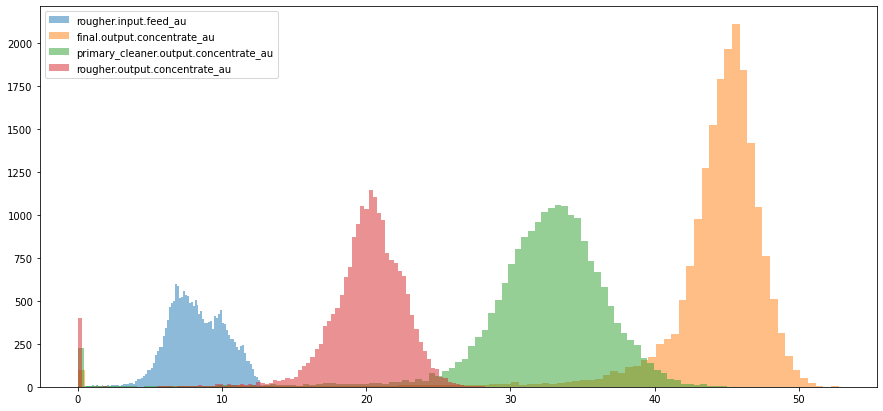

median of rougher.input.feed_ag in data = 8.593574167368724
median of final.output.concentrate_ag in data = 5.066039118467836
median of primary_cleaner.output.concentrate_ag in data = 8.507297972365805
median of rougher.output.concentrate_ag in data = 12.098114967346191


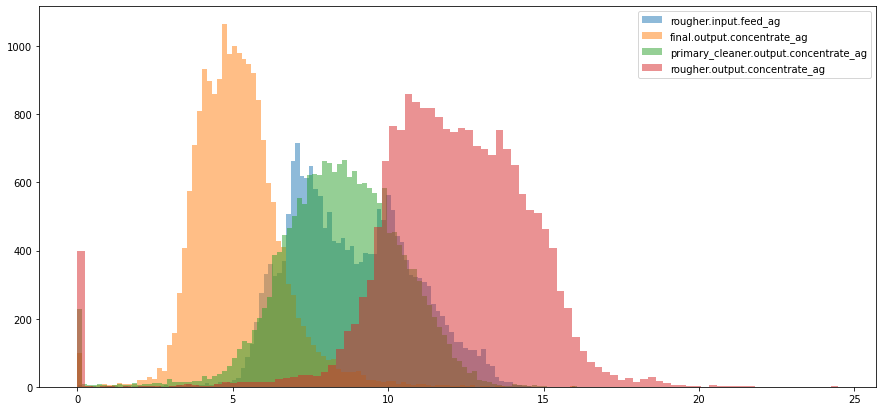

median of rougher.input.feed_pb in data = 3.5282347219520145
median of final.output.concentrate_pb in data = 10.10226350598865
median of primary_cleaner.output.concentrate_pb in data = 10.142270415359071
median of rougher.output.concentrate_pb in data = 7.742580079502529


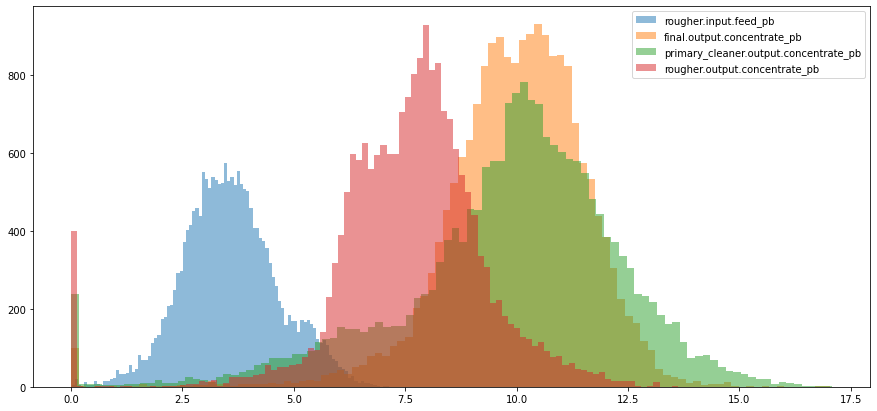

In [ ]:
for var in ['au', 'ag', 'pb']:
    plt.figure(figsize=(15,7))
    for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
        print(f'median of {param} in data =', data[param].median())
        plt.hist(data[param], bins=100, alpha=0.5, label=param);
    plt.legend(loc='best')
    plt.show();

**Исходя из данных выше можно сделать следующие выводы:**
- Концентрация золота по мере прохождения последовательных этапов технологического процесса (очистки и обогащения) сильно возрастает;
- Концентрация серебра вырастает после этапа флотации, а затем по мере прохождения остальных этапов технологического процесса падает;
- Концентрация свинца по мере прохождения этапов технологического процесса слабо растет, при этом после 1-го этапа очистки и на финальной стадии почти не отличается;
- В данных концентрации каждого из металлов есть значения-выбросы равные нулю, которые могут влиять на дальнейшую работу модели и метрику sMAPE, необходимо оценить, какой процент данных охватывают данные значения в тренировочной выборке.

In [ ]:
for var in ['au', 'ag', 'pb']:
    for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
        percent = data[data[param] == 0]['date'].count()/len(data)*100
        print(f'Процент нулевых значений параметра {param} = {percent:.3f}')

Процент нулевых значений параметра rougher.input.feed_au = 0.000
Процент нулевых значений параметра final.output.concentrate_au = 0.504
Процент нулевых значений параметра primary_cleaner.output.concentrate_au = 0.556
Процент нулевых значений параметра rougher.output.concentrate_au = 2.027
Процент нулевых значений параметра rougher.input.feed_ag = 0.000
Процент нулевых значений параметра final.output.concentrate_ag = 0.504
Процент нулевых значений параметра primary_cleaner.output.concentrate_ag = 0.556
Процент нулевых значений параметра rougher.output.concentrate_ag = 2.027
Процент нулевых значений параметра rougher.input.feed_pb = 0.000
Процент нулевых значений параметра final.output.concentrate_pb = 0.504
Процент нулевых значений параметра primary_cleaner.output.concentrate_pb = 0.586
Процент нулевых значений параметра rougher.output.concentrate_pb = 2.027


**Видим, что нулевых значений концентрации металлов среди параметров, характеризующих исходное сырье, нет.**

**Посмотрим теперь суммарный процент данных, в которых хотя бы один из параметров концентрации равен 0.**

In [ ]:
index_zero_conc = [] #список индексов в исходных данных, где хотя бы один из параметров концентрации = 0
conc_param_list = [] #список всех параметров концентрации металлов
for var in ['concentrate_au', 'concentrate_ag', 'concentrate_pb']:
    for i in range(len(str_in_param(var, data))):
        t = str_in_param(var, data)[i]
        conc_param_list.append(t)
        index_zero_conc.extend(data[data[t] == 0].index)
print(f'Процент данных с хотя бы одним параметров концентрации равным нулю: {len(index_zero_conc)/len(data)*100:.3f}')
conc_param_list

Процент данных с хотя бы одним параметров концентрации равным нулю: 9.291


['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au',
 'final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.concentrate_pb']

**Видим, что процент данных значений-выбросов в исходных данных не велик, поэтому можно строки с данным  значением отбросить в тренировочной выборке. Сделаем это, используя признак `date` из исходных данных, т.к. тренировочную выборку мы ранее уже адаптировали под тестовую, убрав из нее некоторые признаки, в том числе и параметры концентрации металлов.**

In [ ]:
time_to_del = data.iloc[index_zero_conc]['date'].tolist()
train_no_zer_conc = train[~train['date'].isin(time_to_del)]
train_zer_conc = train[train['date'].isin(time_to_del)]
print(f"Процент данных, удал-ых из трен. выборки = {(100*len(train_zer_conc)/len(train)):.3f}")
train = train[~train['date'].isin(time_to_del)]

Процент данных, удал-ых из трен. выборки = 3.032


### Оценка распределения размеров гранул сырья

**Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.**

median of primary_cleaner.input.feed_size in train = 7.300
median of primary_cleaner.input.feed_size in test = 7.250


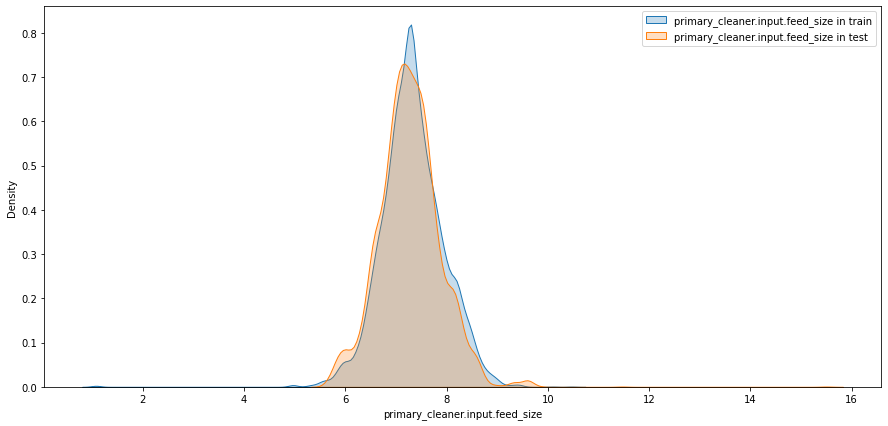



median of rougher.input.feed_size in train = 55.395
median of rougher.input.feed_size in test = 50.847


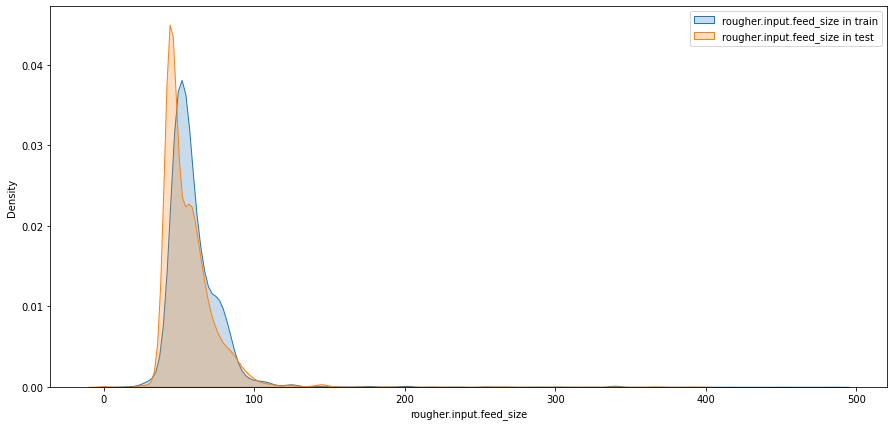

In [ ]:
dict_df = {'train': train, 'test': test}
for param in str_in_param('feed_size', data):
    plt.figure(figsize=(15,7))
    for key in dict_df:
        print(f"median of {param} in {key} = {dict_df[key][param].median():.3f}")
        sns.kdeplot(dict_df[key][param], label=f'{param} in {key}', shade=True);
    plt.legend(loc='best')
    plt.show();
    print('\n')

**Видим, что распределение размеров гранул на каждом из соответствующих этапов очень похоже для тестовой и тренировочной выборок.**

### Исследуем суммарную концентрацию всех веществ на разных стадиях

In [ ]:
display(str_in_param('concentrate', data)) #проверим, какие параметры-концентрации есть у нас в данных
str_in_param('feed_', data) #проверим, какие параметры-концентрации есть у нас в данных для исходного сырья

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

['primary_cleaner.input.feed_size',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

**Видим, что есть четыре интересующих нас вещества на каждом из четырех этапов:**
- `ag`,
- `pb`,
- `sol`,
- `au`.

**Проверим теперь распределение суммарной концентрации данных четырех веществ на каждом из четырех этапов.**

median of rougher.input.feed_sum = 57.594
median of rougher.output.concentrate_sum = 70.181
median of primary_cleaner.output.concentrate_sum = 62.498
median of final.output.concentrate_sum = 69.598


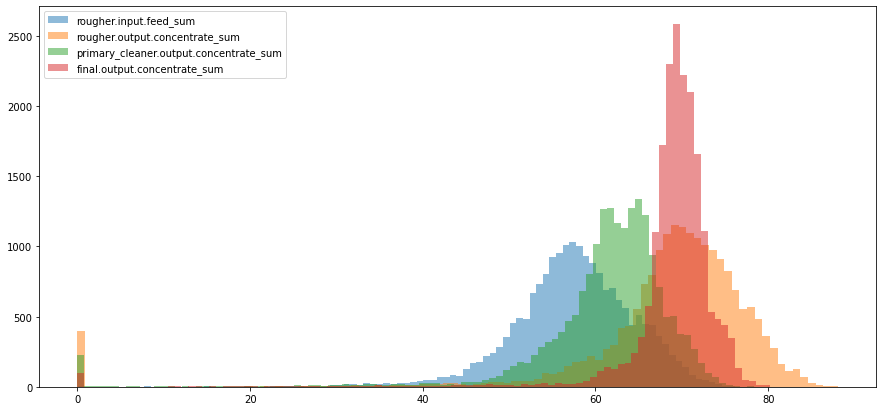

In [ ]:
dict_param = {
    'rougher.input': 'rougher.input.feed',
    'rougher.output': 'rougher.output.concentrate',
    'primary_cleaner': 'primary_cleaner.output.concentrate',
    'final': 'final.output.concentrate'
             }
df = data.copy()
sum_str = '_sum'
plt.figure(figsize=(15,7))
for key in dict_param:
    df[dict_param[key]+sum_str] = df[
        [x for x in str_in_param(dict_param[key], df) if ('_size' not in x) and ('_rate' not in x)]
                                    ].sum(axis=1)
    print(f"median of {dict_param[key]+sum_str} = {df[dict_param[key]+sum_str].median():.3f}")
    plt.hist(df[dict_param[key]+sum_str], bins=100, alpha=0.5, label=f'{dict_param[key]+sum_str}')
plt.legend(loc='best')
plt.show()

**Видим достаточно странную картину: суммарная концентрация в исходном сырье минимальная, далее в черновом концентрате и финальном концентрате почти одинакова и достигает максимальных значений, а вот в концентрате после первичной очистки она меньше, чем концентрация в черновом концентрате, но больше, чем в исходном сырье. Возможно, это как-то связано с технологическим процессом и на этой стадии какая-то часть указанных веществ в бОльшей степени уходят в отвальные хвосты или преобразуются во что-то другое.**

**В данных суммарной концентрации есть значения-выбросы равные нулю, которые являются аномалиями (суммарная концентрация веществ = 0 явно странное явление) и могут влиять на дальнейшую работу модели и метрику sMAPE, необходимо оценить, какой процент данных охватывают данные значения в тренировочной выборке, сделаем это ниже.**

In [ ]:
index_zero_sum_conc = [] #список индексов в исходных данных, где суммарная концентрация хотя бы на одном из этапов = 0
# #conc_param_list = [] #список всех параметров концентрации металлов

for param in str_in_param('_sum', df):
    index_zero_sum_conc.extend(df[df[param] == 0].index)
print(f'Процент исходных данных, где хотя бы один из параметров суммарной концентрации равен нулю: {len(index_zero_sum_conc)/len(df)*100:.3f}')

Процент исходных данных, где хотя бы один из параметров суммарной концентрации равен нулю: 3.087


**Видим, что процент данных значений-выбросов в исходных данных не велик, поэтому можно строки с данным  значением отбросить в тренировочной выборке. Сделаем это, используя признак `date` из исходных данных.**

In [ ]:
time2_to_del = df.iloc[index_zero_sum_conc]['date'].tolist()
train_no_zer_sum_conc = train[~train['date'].isin(time2_to_del)]
train_zer_sum_conc = train[train['date'].isin(time2_to_del)]
print(f"Процент данных, удал-ых из трен. выборки = {(100*len(train_zer_sum_conc)/len(train)):.3f}")
train = train[~train['date'].isin(time2_to_del)]

Процент данных, удал-ых из трен. выборки = 0.000


**Видим, что из тренировочной выборки данные, которые содержат метку времени, соответствующую суммарной концентрации веществ на любом из этап технологического процесса, равной нулю, отсутствуют.**

## Модель

### Функция для вычисления итоговой sMAPE

In [ ]:
def smape(target, predict):
    """Функция для вычисления метрики sMAPE, принимает на вход два pandas.df\series - таргет и предикт"""
    smape = 0
    #стандартизируем индексы у двух выборок
    target_stnd = pd.DataFrame(target).reset_index(drop=True)
    predict_stnd = pd.DataFrame(predict).reset_index(drop=True)

    #создаем общий датафрейм
    merged_df = pd.merge(target_stnd, predict_stnd, left_index=True, right_index=True, how='left')
    #создаем параметр модуль разности предикта и таргета
    merged_df['abs_of_diff'] = abs(merged_df[merged_df.columns[0]] - merged_df[merged_df.columns[1]])
    #создаем параметр сумма модулей предикта и таргета
    merged_df['sum_of_abs'] = abs(merged_df[merged_df.columns[0]]) + abs(merged_df[merged_df.columns[1]])
    #создаем параметр составной член smape согласно предложенной формуле (часть под знаком суммы)
    merged_df['smape_unit'] = 200 * merged_df['abs_of_diff'] / merged_df[merged_df['sum_of_abs'] != 0]['sum_of_abs']
    #вычисляем smape согласно предложенной формуле
    smape = merged_df['smape_unit'].sum() / len(merged_df)
    return smape

def overall_smape(smape_rougher, smape_final):
    """
    Функция для вычисления итоговой метрики sMAPE
    """
    overall_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return overall_smape

**Перед тем, как использовать выборки для обучения и тестирования моделей, необходимо удалить параметры с нечисловым типом данных - параметр `date`, провести масштабирование и разделить выборки на features и target.**

In [ ]:
train = train.drop(['date'], axis=1) #удалим нечисловой параметр date
test = test.drop(['date'], axis=1) #удалим нечисловой параметр date
columns_diff(train, test) # проверим совпадение параметров в двух выборках

'Параметры/столбцы двух выборок не отличаются'

**Выделим из тренировочной и тестовой выборок субвыборки features и target и проведем масштабирование параметров.**

In [ ]:
def target_features_div(target, df):
    """
    Функция, которая разделяет исходную выборку на features и target
    """
    features_df = df.drop(target, axis=1)
    target_df = df[target]
    return features_df, target_df

features_train, target_train = target_features_div(['rougher.output.recovery', 'final.output.recovery'], train)
features_test, target_test = target_features_div(['rougher.output.recovery', 'final.output.recovery'], test)

# нормализуем численные признаки
scaler = MinMaxScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
features_test = pd.DataFrame(scaler.transform(features_test))

print('Информация по тренировочной выборке')
print('Размер features_train')
display(features_train.shape)
print('Размер target_train')
display(target_train.shape)

print(2*'\n'+'Информация по тестовой выборке')
print('Размер features_test')
display(features_test.shape)
print('Размер target_test')
display(target_test.shape)

print('Отличия выборок features_train и features_test:')
columns_diff(features_train, features_test)

Информация по тренировочной выборке
Размер features_train


(13720, 52)

Размер target_train


(13720, 2)



Информация по тестовой выборке
Размер features_test


(5290, 52)

Размер target_test


(5290, 2)

Отличия выборок features_train и features_test:


'Параметры/столбцы двух выборок не отличаются'

**Т.к. у нас в случае нашей задачи два отдельных целевых признака, необходимо полученные выше выборки target разделить на две - с суффиксами rougher и final.**

In [ ]:
target_test_rougher = target_test['rougher.output.recovery']
target_train_rougher = target_train['rougher.output.recovery']
target_test_final = target_test['final.output.recovery']
target_train_final = target_train['final.output.recovery']

### Обучение моделей и оценка их качества кросс-валидацией

**Для текущей задачи предлагаю выбрать две модели - линейная регрессия и дерево решений. Одну из них будем использовать для предсказания одного целевого признака, вторую - для другого целевого признака. Для поиска набора гиперпараметров, дающих наилучший результат метрики sMAPE, будем использовать инструмент GridSearchCV, который в своем механизме также использует кросс-валидацию, что удовлетворяет условиям нашей задачи.**

#### Линейная регрессия и целевой признак rougher.recovery

In [ ]:
model_linreg_rougher = LinearRegression()
smap_scorer = make_scorer(score_func=smape, greater_is_better=False)
gridsearch_linreg_rougher = GridSearchCV(estimator=model_linreg_rougher, param_grid={}, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_linreg_rougher.fit(features_train, target_train_rougher)
print(f'sMAPE lin_reg {-1 * gridsearch_linreg_rougher.best_score_}')

sMAPE lin_reg 7.266314229938172


#### Линейная регрессия и целевой признак final.recovery

In [ ]:
model_linreg_final = LinearRegression()
gridsearch_linreg_final = GridSearchCV(estimator=model_linreg_final, param_grid={}, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_linreg_final.fit(features_train, target_train_final)
print(f'sMAPE lin_reg {-1 * gridsearch_linreg_final.best_score_}')

sMAPE lin_reg 10.947561977457543


#### Решающее дерево для регрессии и целевой признак rougher.recovery

In [ ]:
model_dtr_rougher = DecisionTreeRegressor(random_state=1)
parameters_dtr_rougher = {'max_depth':range(1,13,2),
                          'criterion':['poisson', 'friedman_mse'],
                          'min_samples_split':range(2,10,2)}
gridsearch_dtr_rougher = GridSearchCV(estimator=model_dtr_rougher, param_grid=parameters_dtr_rougher, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dtr_rougher.fit(features_train, target_train_rougher)
print(f'Лучшие параметры dec_tree_reg {gridsearch_dtr_rougher.best_params_}')
print(f'sMAPE dec_tree_reg {-1 * gridsearch_dtr_rougher.best_score_}')

Лучшие параметры dec_tree_reg {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2}
sMAPE dec_tree_reg 7.324978585691332


#### Решающее дерево для регрессии и целевой признак final.recovery

In [ ]:
model_dtr_final = DecisionTreeRegressor(random_state=1)
parameters_dtr_final = {'max_depth':range(1,13,2),
                        'criterion':['poisson', 'friedman_mse'],
                        'min_samples_split':range(2,10,2)}
gridsearch_dtr_final = GridSearchCV(estimator=model_dtr_final, param_grid=parameters_dtr_final, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dtr_final.fit(features_train, target_train_final)
print(f'Лучшие параметры dec_tree_reg {gridsearch_dtr_final.best_params_}')
print(f'sMAPE dec_tree_reg {-1 * gridsearch_dtr_final.best_score_}')

Лучшие параметры dec_tree_reg {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2}
sMAPE dec_tree_reg 9.429629211565247


**Отсюда делаем вывод, что из выбранных двух моделей наилучший результат для признака final.recovery показала модель решающее дерево регрессии, а для признака rougher.recovery - наилучший результат показала модель линейная регрессия.**

**Проверим теперь выбранные модели на тестовой выборке.**

In [ ]:
best_model_final = gridsearch_dtr_final.best_estimator_
best_model_rougher = gridsearch_linreg_rougher.best_estimator_
smape_test_rougher = smape(target_test_rougher, best_model_rougher.predict(features_test))
smape_test_final = smape(target_test_final, best_model_final.predict(features_test))
print(f'sMAPE на тестовой выборке для целевого параметра rougher = {smape_test_rougher:.3f}')
print(f'sMAPE на тестовой выборке для целевого параметра final = {smape_test_final:.3f}')
print(f'Итоговое sMAPE на тестовой выборке = {overall_smape(smape_test_rougher, smape_test_final):.3f}')

sMAPE на тестовой выборке для целевого параметра rougher = 8.563
sMAPE на тестовой выборке для целевого параметра final = 9.925
Итоговое sMAPE на тестовой выборке = 9.584


**Вывод.**

**В итоге лучший результат получила комбинация двух моделей для каждого из целевых параметров, а именно - линейная регрессия для параметра rougher.recovery и решающее дерево для параметра final.recovery. Итоговое значение sMAPE на тестовой выборке получилось 9.584.**

## Проверка моделей на адекватность

**Проверим выбранные модели на адекватность с помощью Dummy Model из класса sklearn, предварительно импортировав ее в первом пункте.**

**Проверка состоит в том, чтобы качество выбранной выше обученной модели было выше, чем качество модели Dummy, которая предсказывает результат не опираясь на признаки тренировочной выборки.**

In [ ]:
#dummy для параметра rougher.recovery
model_dummy_rougher = DummyRegressor()
parameters_dummy_rougher = {'strategy':['mean', 'median', 'constant'],
                            'constant':(0,100,1)}
gridsearch_dummy_rougher = GridSearchCV(estimator=model_dummy_rougher, param_grid=parameters_dummy_rougher, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dummy_rougher.fit(features_train, target_train_rougher)
print(f'Лучшие параметры dummy для rougher.recovery {gridsearch_dummy_rougher.best_params_}')
print(f'sMAPE-dummy rougher.recovery {abs(gridsearch_dummy_rougher.best_score_)}')

Лучшие параметры dummy для rougher.recovery {'constant': 0, 'strategy': 'mean'}
sMAPE-dummy rougher.recovery 7.802275782795165


In [ ]:
# dummy для параметра final.recovery
model_dummy_final = DummyRegressor()
parameters_dummy_final = {'strategy':['mean', 'median', 'constant'],
                          'constant':(0,100,1)}
gridsearch_dummy_final = GridSearchCV(estimator=model_dummy_final, param_grid=parameters_dummy_final, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dummy_final.fit(features_train, target_train_final)
print(f'Лучшие параметры dummy для final.recovery {gridsearch_dummy_final.best_params_}')
print(f'sMAPE-dummy final.recovery {abs(gridsearch_dummy_final.best_score_)}')

Лучшие параметры dummy для final.recovery {'constant': 0, 'strategy': 'mean'}
sMAPE-dummy final.recovery 10.403313462592402


In [ ]:
best_dummy_final = gridsearch_dummy_final.best_estimator_
best_dummy_rougher = gridsearch_dummy_rougher.best_estimator_
smape_test_dummy_rougher = smape(target_test_rougher, best_dummy_rougher.predict(features_test))
smape_test_dummy_final = smape(target_test_final, best_dummy_final.predict(features_test))
print(f'sMAPE-dummy на тестовой выборке для целевого параметра rougher = {smape_test_dummy_rougher:.3f}')
print(f'sMAPE-dummy на тестовой выборке для целевого параметра final = {smape_test_dummy_final:.3f}')
print(f'Итоговое sMAPE-dummy на тестовой выборке = {overall_smape(smape_test_dummy_rougher, smape_test_dummy_final):.3f}')

sMAPE-dummy на тестовой выборке для целевого параметра rougher = 9.063
sMAPE-dummy на тестовой выборке для целевого параметра final = 10.084
Итоговое sMAPE-dummy на тестовой выборке = 9.829


**ВЫВОД**

**В итоге с помощью Dummy модели удалось получить наилучшее качество модели с итоговым sMAPE равным 9.829 при выборе стратегии заполнения средними значениями, что ниже наилучшего результата выбранных и обученных моделей линейной регрессии и регрессии решающего дерева, комбинация которых дала результат итогового sMAPE равный 9.584. Что доказывает адекватность найденной нами модели.**

**Целевого показателя итоговой метрики sMAPE в исходных условиях задачи нет, в дальнейшем мы можем модифицировать модели для улучшения метрики sMAPE путём подбора гиперпараметров или с помощью тестирования других моделей.**